In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import pyrosm as pyr

from utilities.plot_utils import stretch_hist, plot_band, describe_tif

path = "/home/jlb/Projects/architecture-of-ml-systems/data/Aachen"

params = {
    "path": path,
    "boundaries_mask": "boundaries_mask.tif",
    "osm_city": [d for d in os.listdir(path) if d.endswith(".osm.pbf")][0],
}


# with rasterio.open(os.path.join(path, "boundaries_mask.tif")) as src:
#     describe_tif(src)
#     # plot
#     plt.figure(figsize=(5, 5))
#     plt.imshow(src.read(1), cmap='Blues')
#     plt.show()


# buildings mask
with rasterio.open(os.path.join(path, "building_mask_dense.tif")) as src:
    describe_tif(src)
    # plot
    plt.figure(figsize=(50, 50))
    plt.imshow(src.read(1), cmap='Blues')
    plt.show()


# sparse buildings mask
# with rasterio.open(os.path.join(path, "building_mask_sparse.tif")) as src:
#     describe_tif(src)
#     # plot
#     plt.figure(figsize=(50, 50))
#     plt.imshow(src.read(1), cmap='Blues')
#     plt.show()
# 


# osm_data = pyr.OSM(os.path.join(path, params["osm_city"]))
# osm_data.get_boundaries().plot()


FileNotFoundError: [Errno 2] No such file or directory: '/home/jlb/Projects/architecture-of-ml-systems/data/Aachen'

In [ ]:
with rasterio.open(os.path.join(path, "openEO.tif")) as src:
    describe_tif(src)
    data = src.read([1,2,3,4, 5,6])
with rasterio.open(os.path.join(path, "building_mask_dense.tif")) as src:
    describe_tif(src)
    labels = src.read(1)


type(data), data.shape, type(labels), labels.shape

Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1802, 'height': 2238, 'count': 6, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 286200.0,
       0.0, -10.0, 5638320.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
SHAPE:		 (2238, 1802)
dtype		 int16
max		 16024
min		 74
mean		 571.7006746550105
std		 391.1989973893292
sum		 2305597930
Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1802, 'height': 2238, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 286200.0,
       0.0, -10.0, 5638320.0), 'blockysize': 2, 'tiled': False, 'interleave': 'band'}
SHAPE:		 (2238, 1802)
dtype		 int16
max		 1
min		 0
mean		 0.1314840823273515
std		 0.33792901387996505
sum		 530259


(numpy.ndarray, (6, 2238, 1802), numpy.ndarray, (2238, 1802))

In [ ]:
data.shape

# R, G, B, B08, B12, B11
# ["B04", "B03", "B02", "B08", "B12", "B11", "SCL"] 

b = {
    "B04": 0,
    "B03": 1,
    "B02": 2,
    "B08": 3,
    "B12": 4,
    "B11": 5,
}
b["B04"]

0

p_down, p_up [ 166.  300.  173. 1184.  372.  816.] [1942. 1737. 1484. 5209. 2534. 3112.]


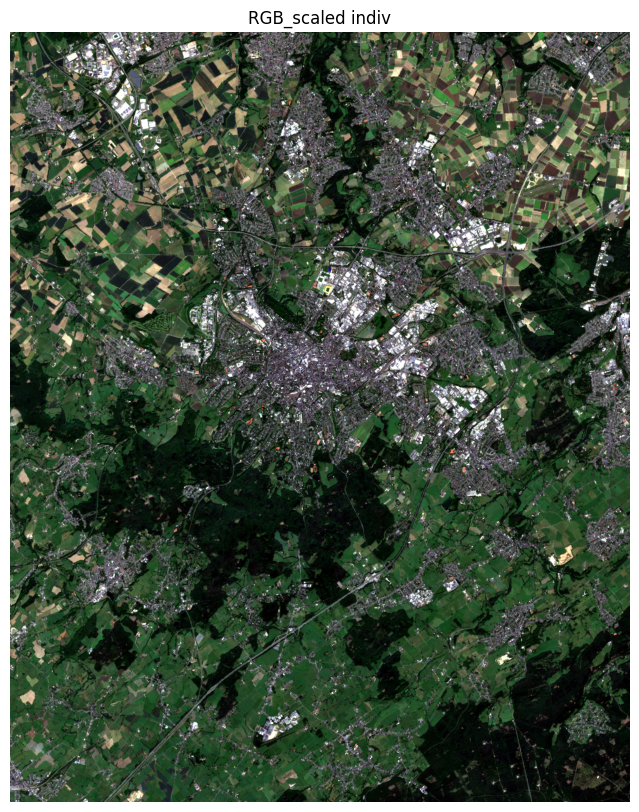

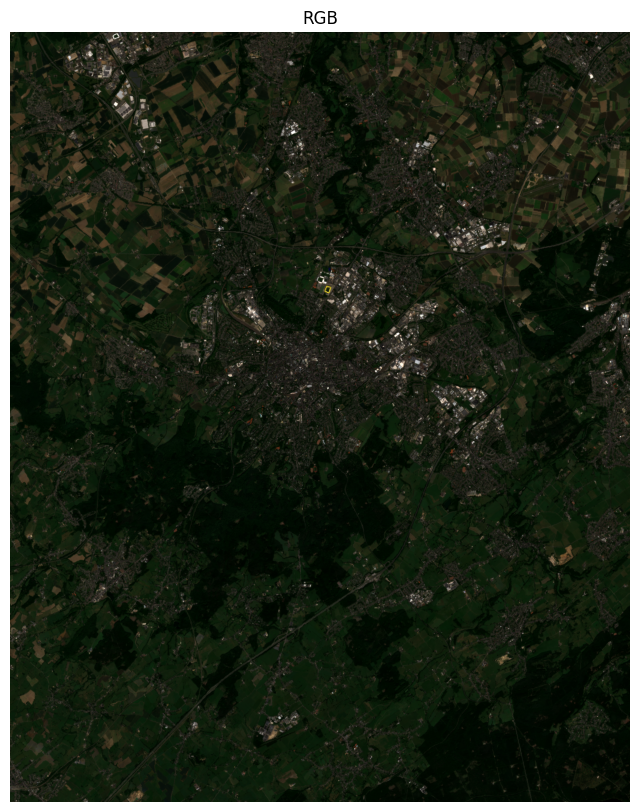

908


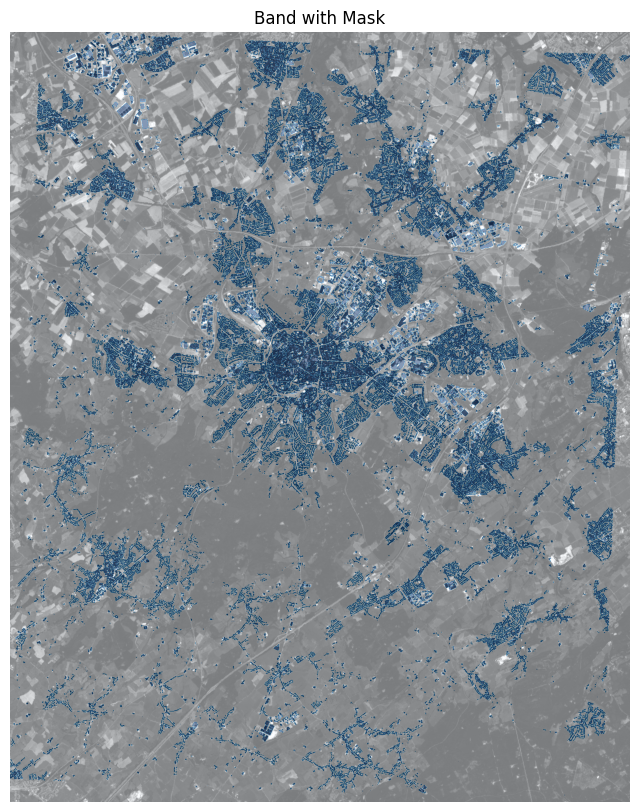

908
0.33467203


In [ ]:
from utilities.plot_utils import plot_bands
# data = stretch_hist(data, 1, 99)
# plot_band(data[0],  cmap='Blues')
# plot_band(data[1], cmap='Blues')
# plot_band(data[2], cmap='Blues')
from utilities.plot_utils import histogram_scaler_bands
plot_bands(histogram_scaler_bands(data, 1, 99), [b["B04"],b["B03"],b["B02"],], "RGB_scaled indiv")
plot_bands(stretch_hist(data, 1, 99), [b["B04"],b["B03"],b["B02"]], "RGB")
print(data[0,0,0])
from utilities.plot_utils import plot_band_with_mask
plot_band_with_mask(stretch_hist(data[0]), labels)
print(data[0,0,0])
print(stretch_hist(data[0])[0,0])

In [10]:
import os
import torch
import tqdm
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm 
# from tqdm import tqdm

class CityDataset(Dataset):
    def __init__(self, 
                 path, # path to the data. Should contain directories of each city with the data
                 patch_size=32, # size of the patches (patch_size x patch_size)
                 transform=None, # transform to apply to the data
                 data_name="openEO.tif", # name of the data file (must be consistent in all directories)
                 labels_name="building_mask_dense.tif", # name of the labels file (must be consistent in all directories)
                 scale_data=True, # if True the data is scaled to 0-1
                 image_bands=[1,2,3,4,5, 6], # bands to load
                 stride=None, # if None stride is equal to patch_size
                 min_labels:float=0.1, # between 0.0 and 1.0, minimum percentage of labels in a patch
                 devrun=False, # if True only load data from the first two cities
                 ):
        self.devrun=devrun
        self.path = path
        self.transform = transform
        self.image_bands = image_bands
        self.scale_data = scale_data
        self.patch_size = patch_size
        self.stride = stride if stride else patch_size
        self.min_labels = min_labels # minimum percentage of labels in a patch

        # get data and labels
        self.data, self.labels = self.__load_data(data_name, labels_name)

        # create patches
        self.X, self.y = self.__create_image_patches()


    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        item = {"data": self.X[idx], "labels": self.y[idx]}
        if self.transform:
            item = self.transform(item)
        return item
    

            
    def __create_image_patches(self):
        # self.__create_image_patches_from_image(self.data[0], self.labels[0])
        assert len(self.data) == len(self.labels), "Data and Labels don't match"
        assert all([d.shape[1] == l.shape[0] and d.shape[2] == l.shape[1] for d, l in zip(self.data, self.labels)]), "Data and Labels don't match"

        X = []
        y = []
        for (d, l) in tqdm(zip(self.data, self.labels), desc="Creating Patches from Images"):
            x, yy = self.__create_image_patches_from_image(d, l)
            X.extend(x)
            y.extend(yy)
        return X, y
        

    def __create_image_patches_from_image(self, image, label_image):
        # print(image.shape)
        width = image.shape[1]
        height = image.shape[2]
        patches = []
        labels = []
        # first check if how many pixels are left in the last patch in each dimension
        left_width = width % self.stride
        left_height = height % self.stride
        # if there are pixels left in the last patch we center the patches, so that the left pixels are distributed equally
        start_width = left_width // 2
        start_height = left_height // 2
        # iterate over the image and create patches
        for i in range(start_width, (width - self.patch_size - start_width + 1), self.stride):
            for j in range(start_height, (height - self.patch_size - start_height + 1), self.stride):

                # check if the patch has enough labels
                label_patch = label_image[i:i+self.patch_size, j:j+self.patch_size]
                if not self.__check_good_labels_ratio(label_patch):
                    continue

                patch = image[:, i:i+self.patch_size, j:j+self.patch_size]
                patches.append(patch)
                labels.append(label_patch)
        # print(len(patches), len(labels))
        return patches, labels



    def __check_good_labels_ratio(self, label_patch):
        return np.sum(label_patch) / (self.patch_size ** 2) >= self.min_labels
        
    def __load_image_data(self, path):
        with rasterio.open(os.path.join(path)) as src:
            data = src.read(self.image_bands)
        if self.scale_data:
            data = self.__scaler(data, 1, 99)
        return data
    
    def __load_data(self, data_name, labels_name): 
        directories = [d for d in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, d)) and not d.startswith(".")]
        # check if ther is a file with name data_name in each directory
        assert all([data_name in os.listdir(os.path.join(self.path, d)) for d in directories]), f"Data file {data_name} not found in all directories"
        assert all([labels_name in os.listdir(os.path.join(self.path, d)) for d in directories]), f"Labels file {labels_name} not found in all directories"
        data_city_paths = [os.path.join(self.path, d, data_name) for d in directories]
        labels_city_paths = [os.path.join(self.path, d, labels_name) for d in directories]
        print("loading data from cities:")
        print([d.split("/")[-2] for d in data_city_paths])

        if self.devrun:
            data_city_paths = data_city_paths[:2]
            labels_city_paths = labels_city_paths[:2]

        return [self.__load_image_data(p) for p in tqdm(data_city_paths, desc="Loading Images")], [self.__load_label_data(p) for p in tqdm(labels_city_paths, desc="Loading Labels")]
    
    @staticmethod
    def __load_label_data(path):
        with rasterio.open(os.path.join(path)) as src:
            data = src.read(1)
        return data

    @staticmethod
    def __scaler(bands, p_low=0.5, p_high=99.5):
        p_down, p_up = np.percentile(bands, (p_low, p_high), axis=(1, 2))
        return np.clip((bands - p_down[:, None, None]) / (p_up - p_down)[:, None, None], 0, 1).astype(np.float32)


dataset = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data/train", devrun=True)


loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/2 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/2 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

In [11]:
# image = np.random.rand(6, 2195, 4101)
# labels = np.random.choice([0,1], size=(2195, 4101))
# print(image.shape)
# print(labels[0:10, 0:10])
# width = image.shape[1]
# height = image.shape[2]
# patches = []
# stride = 32
# patch_size = 32


# # first check if how many pixels are left in the last patch in each dimension
# left_width = width % stride
# left_height = height % stride
# # if there are pixels left in the last patch we center the patches, so that the left pixels are distributed equally
# start_width = left_width // 2
# start_height = left_height // 2
# print("lw",left_width, "lh", left_height, "sw", start_width, "sh", start_height)
# # iterate over the image and create patches
# # Iterate over the image and create patches
# for i in range(start_width, (width - patch_size - start_width + 1), stride):
#     for j in range(start_height, (height - patch_size - start_height + 1), stride):
#         # Create patches
#         # check if patch has labels that are not all 0
#         # if not continue
#         labels_patch = labels[i:i + patch_size, j:j + patch_size]
        
        
#         patch = image[:, i:i + patch_size, j:j + patch_size]


#         # print(patch.shape)
#         patches.append(patch)

# patches = np.array(patches)


# patches.shape, patches[1].shape, patches[-1].shape, patches[-1000].shape

In [12]:
# i = 2
# j = 2
# print(i*patch_size, (i + 1)*patch_size)

In [13]:
dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [15]:
next(iter(dl))["data"].shape, next(iter(dl))["labels"].shape

(torch.Size([32, 6, 32, 32]), torch.Size([32, 32, 32]))

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Generating a synthetic dataset
# Let's assume X contains features and y contains labels
np.random.seed(42)
X = np.random.rand(100, 5)  # 100 samples, 5 features each
y = np.random.randint(0, 2, 100)  # 100 labels, 3 classes

# Initialize StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for the training and validation sets
for train_idx, val_idx in strat_split.split(X, y):
    print(train_idx)
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

# Verify the splits
train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)

train_distribution = dict(zip(train_labels, train_counts))
val_distribution = dict(zip(val_labels, val_counts))

print("Train Distribution:", train_distribution)
print("Validation Distribution:", val_distribution)


[95 89 67 44 41 30 59 10 45 84 56  5  2 22 65 13 33 82 43 91  7 50 63 83
 14 97 88 38  8 35 96 62 49 69 52 29 51 73 24 80 20 12 60 78 86 87  0 57
  4 55 94 76 58 64 28 34 48  3 25 81 93 71 54 98 40 90 85 77 53 46 68 21
 42 72 19 23 70 26 74  1]
Train Distribution: {0: 48, 1: 32}
Validation Distribution: {0: 12, 1: 8}
